In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_color_codes()
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from IPython.display import Image
import pydotplus     
import os
import mglearn
#import urllib
import sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from dython import nominal
import scipy
from scipy.stats import chi2_contingency 
from sklearn import preprocessing

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
import nltk
import re
from nltk.stem.snowball import SnowballStemmer
stop_words = set(stopwords.words("english"))
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 1. import data ##

In [2]:
data1 = pd.read_csv("data1.csv")

## 2. data preprocessing ##

In [3]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28543 entries, 0 to 28542
Data columns (total 14 columns):
ReferenceID             28543 non-null object
ReportYear              28543 non-null int64
DiagnosisCategory       28543 non-null object
DiagnosisSubCategory    28519 non-null object
TreatmentCategory       28543 non-null object
TreatmentSubCategory    28541 non-null object
Determination           28543 non-null object
Type                    28543 non-null object
AgeRange                27852 non-null object
PatientGender           27852 non-null object
IMRType                 28543 non-null object
DaysToReview            27881 non-null float64
DaysToAdopt             28543 non-null int64
Findings                28543 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 3.0+ MB


### 2.1. Remove meaningless variables such as year, ID ###

In [4]:
classification = data1[['DiagnosisCategory','DiagnosisSubCategory',
                        'TreatmentCategory','TreatmentSubCategory','Determination',
                        'Type','AgeRange','PatientGender','IMRType','DaysToReview','DaysToAdopt']]

### 2.2. Check data type ###

In [5]:
classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28543 entries, 0 to 28542
Data columns (total 11 columns):
DiagnosisCategory       28543 non-null object
DiagnosisSubCategory    28519 non-null object
TreatmentCategory       28543 non-null object
TreatmentSubCategory    28541 non-null object
Determination           28543 non-null object
Type                    28543 non-null object
AgeRange                27852 non-null object
PatientGender           27852 non-null object
IMRType                 28543 non-null object
DaysToReview            27881 non-null float64
DaysToAdopt             28543 non-null int64
dtypes: float64(1), int64(1), object(9)
memory usage: 2.4+ MB


### 2.3. Check missing value ###

In [6]:
classification.isnull().sum()

DiagnosisCategory         0
DiagnosisSubCategory     24
TreatmentCategory         0
TreatmentSubCategory      2
Determination             0
Type                      0
AgeRange                691
PatientGender           691
IMRType                   0
DaysToReview            662
DaysToAdopt               0
dtype: int64

### 2.4. Remove missing value ###

In [7]:
data_c = classification.dropna(axis=0)

### 2.5. Check missing value ###

In [8]:
data_c.isnull().sum()

DiagnosisCategory       0
DiagnosisSubCategory    0
TreatmentCategory       0
TreatmentSubCategory    0
Determination           0
Type                    0
AgeRange                0
PatientGender           0
IMRType                 0
DaysToReview            0
DaysToAdopt             0
dtype: int64

### 2.6. Check size of class for specific variables ###

Some variable have too many categories which leads labeling of classification meaningless.

In [9]:
category_feature = [ col for col in data_c.columns if data_c[col].dtypes == "object"]
category_feature

['DiagnosisCategory',
 'DiagnosisSubCategory',
 'TreatmentCategory',
 'TreatmentSubCategory',
 'Determination',
 'Type',
 'AgeRange',
 'PatientGender',
 'IMRType']

In [10]:
 data_c["DiagnosisSubCategory"].describe()

count     27165
unique      390
top       Other
freq       5205
Name: DiagnosisSubCategory, dtype: object

In [11]:
 data_c["DiagnosisCategory"].describe()

count                    27165
unique                      29
top       Orth/Musculoskeletal
freq                      4752
Name: DiagnosisCategory, dtype: object

In [12]:
data_c["TreatmentSubCategory"].describe()

count     27165
unique      362
top       Other
freq       6593
Name: TreatmentSubCategory, dtype: object

In [13]:
data_c["TreatmentCategory"].describe()

count        27165
unique          33
top       Pharmacy
freq          6682
Name: TreatmentCategory, dtype: object

### 2.7 EDA - Bar_graph for variables ###

I have plotted bar graph for all variables except Diagnosis Sub Category and treatment Sub Category because they have more than 300 levels.

In [14]:
def bar_chart(feature):
    Upheld = data_c[data_c['Determination']=='Upheld Decision of Health Plan'][feature].value_counts()
    Overturned = data_c[data_c['Determination']=='Overturned Decision of Health Plan'][feature].value_counts()
    df = pd.DataFrame([Upheld,Overturned])
    df.index = ['Upheld','Overturned']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
    ax = plt.subplot()
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Upheld', 'Overturned'], rotation=0, fontsize=15)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


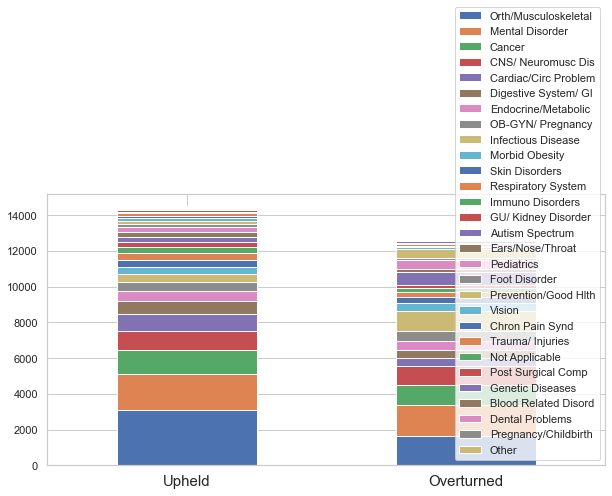

In [15]:
bar_chart('DiagnosisCategory')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


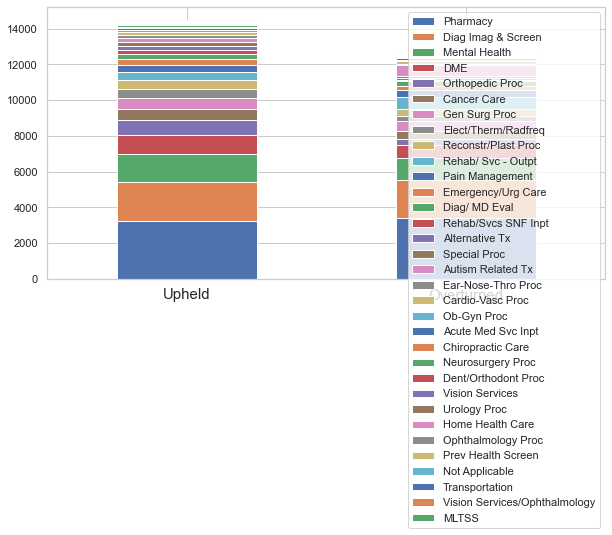

In [16]:
bar_chart('TreatmentCategory')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


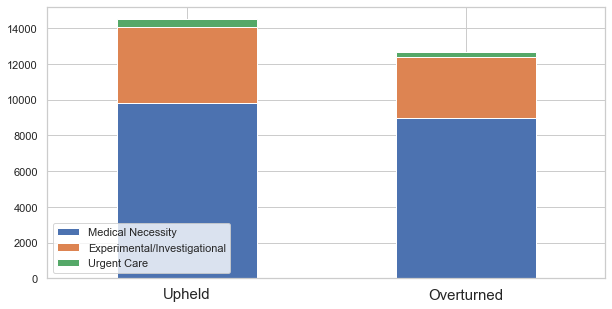

In [17]:
bar_chart('Type')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


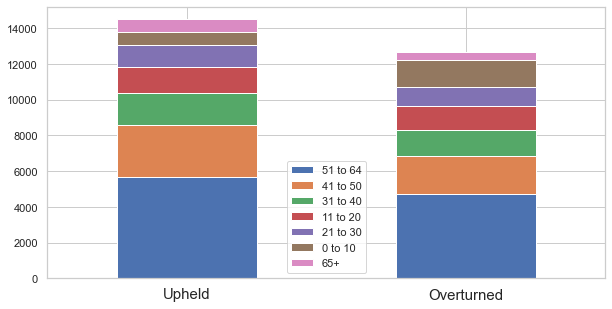

In [18]:
bar_chart('AgeRange')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


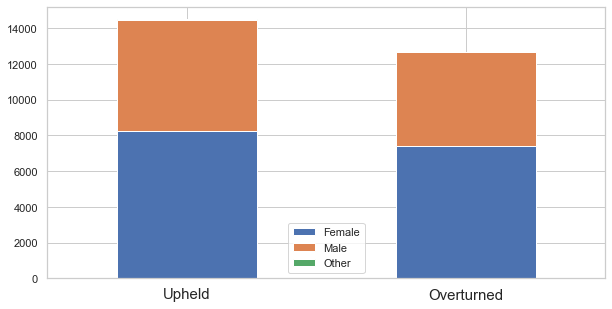

In [19]:
bar_chart('PatientGender')

### 2.8. Select variables ###

DiagnosisSubCategory and DiagnosisSubCategory have too many categories (390 and 362)
Therefore, I'll remove this two variables. However, I'll use those variables in detailed version.

In [20]:
data_c = data_c[['DiagnosisCategory','TreatmentCategory','Determination','Type','AgeRange','PatientGender','IMRType']]

In [21]:
categorical_variables = ['DiagnosisCategory','TreatmentCategory','Type','AgeRange','PatientGender','IMRType']

#### 2.8.1 Check Cramer's v test for regular version ####

In [22]:
data_cramer = data_c[['DiagnosisCategory','TreatmentCategory','Type','AgeRange','PatientGender','IMRType']]

In [23]:
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()

for i in data_cramer.columns:
    data_encoded[i]=label.fit_transform(data_cramer[i])

In [24]:
data_encoded.head()

,DiagnosisCategory,TreatmentCategory,Type,AgeRange,PatientGender,IMRType
0,26,25,1,5,1,1
1,11,19,1,3,0,1
2,3,8,0,6,1,1
3,19,5,1,4,1,1
4,15,16,1,1,0,1


In [25]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [26]:
rows= []

for var1 in data_encoded:
    col = []
    for var2 in data_encoded :
        cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)



df

,DiagnosisCategory,TreatmentCategory,Type,AgeRange,PatientGender,IMRType
DiagnosisCategory,1.00,0.18,0.11,0.13,0.05,0.07
TreatmentCategory,0.18,1.00,0.52,0.10,0.03,0.11
Type,0.11,0.52,1.00,0.02,0.00,0.01
AgeRange,0.13,0.10,0.02,1.00,0.02,0.00
PatientGender,0.05,0.03,0.00,0.02,1.00,0.00
IMRType,0.07,0.11,0.01,0.00,0.00,1.00


#### 2.8.2. Visualize Cramer's v test for regular version ####

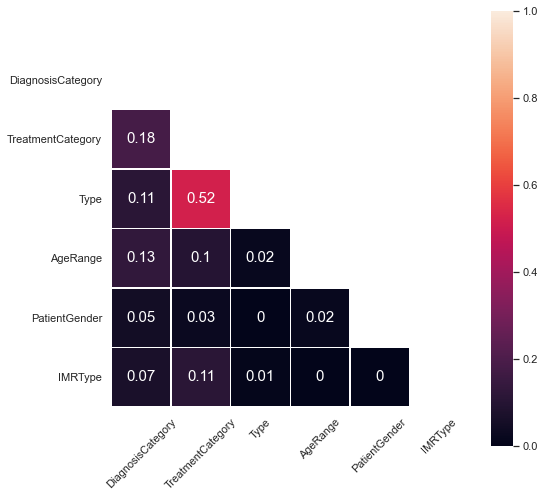

In [27]:
plt.figure(figsize=(8,8))
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True




with sns.axes_style("white"):
    ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True,linewidths=.5, annot=True, annot_kws={"size": 15})
plt.xticks(rotation =  45 )
plt.show()


### 2.9. One-hot coding ###

In [28]:
for variable in categorical_variables:
    data_c[variable].fillna("Missing",inplace=True)
    dummies = pd.get_dummies(data_c[variable],prefix=variable)
    data_c = pd.concat([data_c,dummies],axis=1)
    data_c.drop([variable],axis=1,inplace=True)

In [29]:
data_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27165 entries, 0 to 28057
Data columns (total 78 columns):
Determination                                      27165 non-null object
DiagnosisCategory_Autism Spectrum                  27165 non-null uint8
DiagnosisCategory_Blood Related Disord             27165 non-null uint8
DiagnosisCategory_CNS/ Neuromusc Dis               27165 non-null uint8
DiagnosisCategory_Cancer                           27165 non-null uint8
DiagnosisCategory_Cardiac/Circ Problem             27165 non-null uint8
DiagnosisCategory_Chron Pain Synd                  27165 non-null uint8
DiagnosisCategory_Dental Problems                  27165 non-null uint8
DiagnosisCategory_Digestive System/ GI             27165 non-null uint8
DiagnosisCategory_Ears/Nose/Throat                 27165 non-null uint8
DiagnosisCategory_Endocrine/Metabolic              27165 non-null uint8
DiagnosisCategory_Foot Disorder                    27165 non-null uint8
DiagnosisCategory_GU/ Kidn

In [30]:
data_c

,Determination,DiagnosisCategory_Autism Spectrum,DiagnosisCategory_Blood Related Disord,DiagnosisCategory_CNS/ Neuromusc Dis,DiagnosisCategory_Cancer,DiagnosisCategory_Cardiac/Circ Problem,DiagnosisCategory_Chron Pain Synd,DiagnosisCategory_Dental Problems,DiagnosisCategory_Digestive System/ GI,DiagnosisCategory_Ears/Nose/Throat,...,AgeRange_21 to 30,AgeRange_31 to 40,AgeRange_41 to 50,AgeRange_51 to 64,AgeRange_65+,PatientGender_Female,PatientGender_Male,PatientGender_Other,IMRType_Expedited,IMRType_Standard
0,Upheld Decision of Health Plan,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,Overturned Decision of Health Plan,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,Upheld Decision of Health Plan,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3,Overturned Decision of Health Plan,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,Upheld Decision of Health Plan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27852,Overturned Decision of Health Plan,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
27901,Overturned Decision of Health Plan,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
28029,Overturned Decision of Health Plan,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
28044,Upheld Decision of Health Plan,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0


### 2.10. Check all variables after one-hot coding ###

In [31]:
def printall(data_c,max_rows=10):
    from IPython.display import display, HTML
    display(HTML(data_c.to_html(max_rows=max_rows)))
    
printall(data_c)

,Determination,DiagnosisCategory_Autism Spectrum,DiagnosisCategory_Blood Related Disord,DiagnosisCategory_CNS/ Neuromusc Dis,DiagnosisCategory_Cancer,DiagnosisCategory_Cardiac/Circ Problem,DiagnosisCategory_Chron Pain Synd,DiagnosisCategory_Dental Problems,DiagnosisCategory_Digestive System/ GI,DiagnosisCategory_Ears/Nose/Throat,DiagnosisCategory_Endocrine/Metabolic,DiagnosisCategory_Foot Disorder,DiagnosisCategory_GU/ Kidney Disorder,DiagnosisCategory_Genetic Diseases,DiagnosisCategory_Immuno Disorders,DiagnosisCategory_Infectious Disease,DiagnosisCategory_Mental Disorder,DiagnosisCategory_Morbid Obesity,DiagnosisCategory_Not Applicable,DiagnosisCategory_OB-GYN/ Pregnancy,DiagnosisCategory_Orth/Musculoskeletal,DiagnosisCategory_Other,DiagnosisCategory_Pediatrics,DiagnosisCategory_Post Surgical Comp,DiagnosisCategory_Pregnancy/Childbirth,DiagnosisCategory_Prevention/Good Hlth,DiagnosisCategory_Respiratory System,DiagnosisCategory_Skin Disorders,DiagnosisCategory_Trauma/ Injuries,DiagnosisCategory_Vision,TreatmentCategory_Acute Med Svc Inpt,TreatmentCategory_Alternative Tx,TreatmentCategory_Autism Related Tx,TreatmentCategory_Cancer Care,TreatmentCategory_Cardio-Vasc Proc,TreatmentCategory_Chiropractic Care,TreatmentCategory_DME,TreatmentCategory_Dent/Orthodont Proc,TreatmentCategory_Diag Imag & Screen,TreatmentCategory_Diag/ MD Eval,TreatmentCategory_Ear-Nose-Thro Proc,TreatmentCategory_Elect/Therm/Radfreq,TreatmentCategory_Emergency/Urg Care,TreatmentCategory_Gen Surg Proc,TreatmentCategory_Home Health Care,TreatmentCategory_MLTSS,TreatmentCategory_Mental Health,TreatmentCategory_Neurosurgery Proc,TreatmentCategory_Not Applicable,TreatmentCategory_Ob-Gyn Proc,TreatmentCategory_Ophthalmology Proc,TreatmentCategory_Orthopedic Proc,TreatmentCategory_Pain Management,TreatmentCategory_Pharmacy,TreatmentCategory_Prev Health Screen,TreatmentCategory_Reconstr/Plast Proc,TreatmentCategory_Rehab/ Svc - Outpt,TreatmentCategory_Rehab/Svcs SNF Inpt,TreatmentCategory_Special Proc,TreatmentCategory_Transportation,TreatmentCategory_Urology Proc,TreatmentCategory_Vision Services,TreatmentCategory_Vision Services/Ophthalmology,Type_Experimental/Investigational,Type_Medical Necessity,Type_Urgent Care,AgeRange_0 to 10,AgeRange_11 to 20,AgeRange_21 to 30,AgeRange_31 to 40,AgeRange_41 to 50,AgeRange_51 to 64,AgeRange_65+,PatientGender_Female,PatientGender_Male,PatientGender_Other,IMRType_Expedited,IMRType_Standard
0,Upheld Decision of Health Plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
1,Overturned Decision of Health Plan,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2,Upheld Decision of Health Plan,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1
3,Overturned Decision of Health Plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1
4,Upheld Decision of Health Plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27852,Overturned Decision of Health Plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
27901,Overturned Decision of Health Plan,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

### 2.11. Divide dataset ###

In [32]:
y = data_c['Determination']
X = data_c.drop('Determination',axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [34]:
len(X_train)

21732

# Modeling #

## 3 Decision Tree ##

### 3.1 Regular Decision Tree ###

#### 3.1.1 Build the model with random parameters ####

In [35]:
model_d = DecisionTreeClassifier(random_state=10)

#### 3.1.2 Fit train data to model ####

In [36]:
model_d = model_d.fit(X_train, y_train)

#### 3.1.3 Check accuracy for train data and test data ####

In [37]:
print("Train Set Score1 : {:.2f}".format(model_d.score(X_train,y_train)))
print("Test Set Score1 : {:.2f}".format(model_d.score(X_test,y_test)))

Train Set Score1 : 0.72
Test Set Score1 : 0.61


#### 3.1.4 Confusion matrix ####

In [38]:
c = data_c.Determination.astype('category')
d = dict(enumerate(c.cat.categories))
print(d)

{0: 'Overturned Decision of Health Plan', 1: 'Upheld Decision of Health Plan'}


In [39]:
confusion_matrix(y_test, model_d.predict(X_test))

array([[1475, 1060],
       [1040, 1858]], dtype=int64)

### 3.2 Grid Search for Regular Decision tree ###

#### 3.2.1 Set the combination of parameters ####

In [40]:
param_dist={"criterion":["gini","entropy"],"max_depth":[1,2,3,4,5,6,7,8,9,10,11,12]}

#### 3.2.2 Make the GridSearch model and Fit it with train data ####

In [41]:
grid_model_d = GridSearchCV(model_d,param_grid=param_dist,cv=10, n_jobs=-1)

In [42]:
grid_model_d.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=10,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},


#### 3.2.3 Check best optimal parameters and build new regular decision tree ####

In [43]:
best_parameters = grid_model_d.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 12}


In [44]:
after_grid_model_d = DecisionTreeClassifier(criterion='gini', max_depth=6,random_state=10)
after_grid_model_d = after_grid_model_d.fit(X_train, y_train)

#### 3.2.4 Check the accuracy of the model after grid search ####

In [45]:
print("Train Set Score1 : {:.4f}".format(after_grid_model_d.score(X_train,y_train)))
print("Test Set Score1 : {:.4f}".format(after_grid_model_d.score(X_test,y_test)))

Train Set Score1 : 0.6091
Test Set Score1 : 0.6056


### 3.3  Make a detailed decision tree model with granular data such as  DiagnosisSubCategory and TreatmentSubCategory variable  ###

It is surprising to find that the accruacy is not higher than 61 %. In order to have higher accuracy, I tried to replace variables that have more granular data such as DiagnosisSubCategory instead of using DiagnosisCategory and TreatSubCategory instead of TreatCategory respectively.

#### 3.3.1 Remove variables we want to replace with and include more detailed variables with granular data ####

In [46]:
classification2 = data1[['ReferenceID','DiagnosisCategory','DiagnosisSubCategory',
                         'TreatmentCategory','TreatmentSubCategory','Determination',
                         'Type','AgeRange','PatientGender','IMRType','DaysToReview','DaysToAdopt']]
data_3 = classification.dropna(axis=0)

In [47]:
category_feature = [ col for col in data_3.columns if data_3[col].dtypes == "object"]

In [48]:
data_3 = data_3[['DiagnosisSubCategory','TreatmentSubCategory','Determination','Type','AgeRange','PatientGender','IMRType']]

In [49]:
categorical_variables2 = ['DiagnosisSubCategory','TreatmentSubCategory','Type','AgeRange','PatientGender','IMRType']

#### 3.3.2 Cramer's V test for detailed variables ####

In [50]:
Cramer_for_detail = data_3[['DiagnosisSubCategory','TreatmentSubCategory','Type','AgeRange','PatientGender','IMRType']]
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame()

for i in Cramer_for_detail.columns:
    data_encoded[i]=label.fit_transform(Cramer_for_detail[i])

In [51]:
data_encoded.head()

,DiagnosisSubCategory,TreatmentSubCategory,Type,AgeRange,PatientGender,IMRType
0,135,5,1,5,1,1
1,142,178,1,3,0,1
2,312,154,0,6,1,1
3,40,133,1,4,1,1
4,113,275,1,1,0,1


In [52]:
rows= []

for var1 in data_encoded:
    col = []
    for var2 in data_encoded :
        cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)



df

,DiagnosisSubCategory,TreatmentSubCategory,Type,AgeRange,PatientGender,IMRType
DiagnosisSubCategory,1.00,0.09,0.18,0.16,0.13,0.11
TreatmentSubCategory,0.09,1.00,0.58,0.15,0.08,0.18
Type,0.18,0.58,1.00,0.02,0.00,0.01
AgeRange,0.16,0.15,0.02,1.00,0.02,0.00
PatientGender,0.13,0.08,0.00,0.02,1.00,0.00
IMRType,0.11,0.18,0.01,0.00,0.00,1.00


#### 3.3.3 Visualize Cramer's V test for detailed variables ####

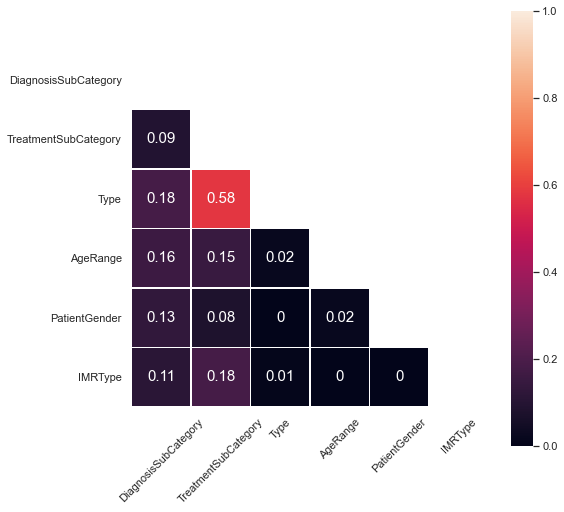

In [53]:
plt.figure(figsize=(8,8))
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True




with sns.axes_style("white"):
    ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True,linewidths=.5, annot=True, annot_kws={"size": 15})
plt.xticks(rotation =  45 )
plt.show()

#### 3.3.4 One-hot coding for detailed variables ####

In [54]:
for variable in categorical_variables2:
    data_3[variable].fillna("Missing",inplace=True)
    dummies = pd.get_dummies(data_3[variable],prefix=variable)
    data_3 = pd.concat([data_3,dummies],axis=1)
    data_3.drop([variable],axis=1,inplace=True)

In [55]:
def printall(data_3,max_rows=10):
    from IPython.display import display, HTML
    display(HTML(data_3.to_html(max_rows=max_rows)))
    
printall(data_3)

,Determination,DiagnosisSubCategory_ACL,DiagnosisSubCategory_ADD,DiagnosisSubCategory_ADHD,DiagnosisSubCategory_AIDS/HIV,DiagnosisSubCategory_ALS,DiagnosisSubCategory_Abdominal Pannus,DiagnosisSubCategory_Abdominal/Stomach Pain,DiagnosisSubCategory_Abscess,DiagnosisSubCategory_Abscess/Infection,DiagnosisSubCategory_Acne,DiagnosisSubCategory_Actinic Kerotosis,DiagnosisSubCategory_Acute Kidney Failure,DiagnosisSubCategory_Addison's Disease,DiagnosisSubCategory_Adenocarcinoma,DiagnosisSubCategory_AlcoholAbuse/Addiction,DiagnosisSubCategory_Allergy,DiagnosisSubCategory_Alopecia,DiagnosisSubCategory_Alzheimer's Disease,DiagnosisSubCategory_Amputation,DiagnosisSubCategory_Anal/Rectal,DiagnosisSubCategory_Anemia,DiagnosisSubCategory_Aneurysm,DiagnosisSubCategory_Angina,DiagnosisSubCategory_Animal Bite,DiagnosisSubCategory_Anorexia/Bulimia,DiagnosisSubCategory_Anxiety,DiagnosisSubCategory_Apnea/Sleep Apnea,DiagnosisSubCategory_Appendicitis,DiagnosisSubCategory_Arrhythmia/Irregular Heart Rhythm,DiagnosisSubCategory_Arthritis,DiagnosisSubCategory_Asbestosis,DiagnosisSubCategory_Asperger Syndrome,DiagnosisSubCategory_Asthma,DiagnosisSubCategory_Astigmatism,DiagnosisSubCategory_Ataxia,DiagnosisSubCategory_Attachment Disorder,DiagnosisSubCategory_Autism-PDD-NOS,DiagnosisSubCategory_Autistic Disorder,DiagnosisSubCategory_Auto Accident,DiagnosisSubCategory_Autoimmune Disease,DiagnosisSubCategory_Back Pain,DiagnosisSubCategory_Back/Neck,DiagnosisSubCategory_Bacterial Infection,DiagnosisSubCategory_Barrett's Esophagus,DiagnosisSubCategory_Beating/ Assault,DiagnosisSubCategory_Bipolar Disorder,DiagnosisSubCategory_Bladder,DiagnosisSubCategory_Bleeding,DiagnosisSubCategory_Blindness,DiagnosisSubCategory_Blood,DiagnosisSubCategory_Blood Clot,DiagnosisSubCategory_Bone,DiagnosisSubCategory_Bone Fracture/Break,DiagnosisSubCategory_Borderline Personality Dis,DiagnosisSubCategory_Brain,DiagnosisSubCategory_Brain Injury/Concussion,DiagnosisSubCategory_Brain Tumor,DiagnosisSubCategory_Breast,DiagnosisSubCategory_Breathing Problem,DiagnosisSubCategory_Bronchitis,DiagnosisSubCategory_Bunion,DiagnosisSubCategory_Burn,DiagnosisSubCategory_Burns,DiagnosisSubCategory_Bursitis,DiagnosisSubCategory_CAD,DiagnosisSubCategory_CHARGE Syndrome,DiagnosisSubCategory_CHF,DiagnosisSubCategory_COPD,DiagnosisSubCategory_Cancer,DiagnosisSubCategory_Cardiac Problem,DiagnosisSubCategory_Cardiac Valve Dis,DiagnosisSubCategory_Cardiac/Circ Problem,DiagnosisSubCategory_Cardiac/Heart Prob,DiagnosisSubCategory_Cardiomyopathy,DiagnosisSubCategory_Carpal Tunnel Synd,DiagnosisSubCategory_Cataracts,DiagnosisSubCategory_Celiac Disease,DiagnosisSubCategory_Cerebral Palsy,DiagnosisSubCategory_Cervical,DiagnosisSubCategory_Chemical Exposure,DiagnosisSubCategory_Chest Pain,DiagnosisSubCategory_Cholecystitis,DiagnosisSubCategory_Chromosomal Anomaly,DiagnosisSubCategory_Chron Kidney Fail,DiagnosisSubCategory_Chron Kidney Failure/ESRD,DiagnosisSubCategory_Chronic Diarrhea,DiagnosisSubCategory_Chronic Fatigue Synd,DiagnosisSubCategory_Chronic Pain Syndrome,DiagnosisSubCategory_Cirrhosis,DiagnosisSubCategory_Cleft Palate/Lip,DiagnosisSubCategory_Colitis/Inflammatory Bowel Disease,DiagnosisSubCategory_Colon,DiagnosisSubCategory_Complex Regional Pain Synd/RSD,DiagnosisSubCategory_Congenital Anomaly,DiagnosisSubCategory_Congenital Deformity,DiagnosisSubCategory_Congenital Heart Dft,DiagnosisSubCategory_Congestive Heart Failure,DiagnosisSubCategory_Constipation,DiagnosisSubCategory_Cornea Problem,DiagnosisSubCategory_Corneal Abrasion,DiagnosisSubCategory_Corneal Ulcers,DiagnosisSubCategory_Corns and Calluses,DiagnosisSubCategory_Coronary Artery Disease,DiagnosisSubCategory_Cough,DiagnosisSubCategory_Crohn's Disease,DiagnosisSubCategory_Crohns Disease,DiagnosisSubCategory_Cyst,DiagnosisSubCategory_Cystic Fibrosis,DiagnosisSubCategory_Decay/ Cavities,DiagnosisSubCategory_Decay/ Root Involve,DiagnosisSubCategory_Deep Vein Thrombosis,DiagnosisSubCategory_Deformities,DiagnosisSubCategory_Delayed Speech

#### 3.3.5 Divide dataset ####

In [56]:
y = data_3['Determination']
X = data_3.drop('Determination',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

#### 3.3.4 Build decision tree with detailed variables and Fit train data ####

In [57]:
model_3 = DecisionTreeClassifier(random_state=10)
model_3 = model_3.fit(X_train, y_train)

#### 3.3.5 Check accuracy of detail decision tree model ####

In [58]:
print("Train Set Score1 : {:.2f}".format(model_3.score(X_train,y_train)))
print("Test Set Score1 : {:.2f}".format(model_3.score(X_test,y_test)))

Train Set Score1 : 0.83
Test Set Score1 : 0.61


By using variables in the dataset with more detailed data, I was able to have 83% accuracy score for train set but 61% for test set.

### 3.4 Grid Search for detail Decision tree  ###

#### 3.4.1 Build Grid search model and check best parameter ####

I applied the same combination of parameters with previous grid search for a detailed decision tree

In [59]:
grid_model_3 = GridSearchCV(model_3,param_grid=param_dist,cv=10, n_jobs=-1)
grid_model_3.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=10,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},


In [60]:
best_parameters = grid_model_3.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 12}


#### 3.4.2 Build model based on best optimal parameters and check the accuracy again ####

In [61]:
after_grid_model_3 = DecisionTreeClassifier(criterion='gini', max_depth=12,random_state=10)
after_grid_model_3 = after_grid_model_3.fit(X_train, y_train)

In [62]:
print("Train Set Score1 : {:.2f}".format(after_grid_model_3.score(X_train,y_train)))
print("Test Set Score1 : {:.2f}".format(after_grid_model_3.score(X_test,y_test)))

Train Set Score1 : 0.64
Test Set Score1 : 0.62


After grid search, I'm still around 62% accuracy level.

### -----------------------------------------------------------------###

## 4 Random Forest ##

### 4.1 Regular Random Forest ###

#### 4.1.1 Build the model and fit the test data ####

In [63]:
model=RandomForestClassifier(100,oob_score=True,n_jobs=-1,random_state=14)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=14, verbose=0,
                       warm_start=False)

#### 4.1.2 Check the accuracy and confusion matrix ####

In [64]:
print("Train Accuracy : {:.3f}".format(model.score(X_train,y_train)))
print("Test Accuracy : {:.3f}".format(model.score(X_test,y_test)))

Train Accuracy : 0.830
Test Accuracy : 0.628


### 4.2 Grid Search for regular Random Forest ###

#### 4.2.1 Set the combination of parameters ####

In [65]:
parameters = {'n_estimators' : [50,100,200,300],
              'criterion': ['gini','entropy'],
              'max_depth' : [5,7,9,11],
              'max_features' : ['auto','sqrt']}


#### 4.2.2 Make the GridSearch model and Fit it with train data ####

In [66]:
gs = GridSearchCV(estimator=model, param_grid=parameters,
                  scoring='accuracy', cv=10, n_jobs=-1,verbose=True)

In [67]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 26.0min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=14,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'criteri

#### 4.2.3 Check best parameters and build new Random Forest ####

In [68]:
best_parameters = gs.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 100}


In [69]:
after_grid_model=RandomForestClassifier(100,oob_score=True,n_jobs=-1,random_state=14,criterion='gini',max_depth=11,max_features='auto')
after_grid_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=14, verbose=0,
                       warm_start=False)

#### 4.2.4 Check the accuracy after grid search ####

In [70]:
print("Train Accuracy : {:.3f}".format(after_grid_model.score(X_train,y_train)))

print("Test Accuracy : {:.3f}".format(after_grid_model.score(X_test,y_test)))

Train Accuracy : 0.638
Test Accuracy : 0.627


### 4.3 Make a random forest model with granular data such as  DiagnosisSubCategory and TreatmentSubCategory variable ###

#### 4.3.1 Divide dataset ####

Originally, this section also should include data preprocessing like one-hot coding. 
But, I'll use same variables with detail decision tree model in 3.3
So, I skip most of data preprocessing for detail variables.

In [71]:
y = data_3['Determination']
X = data_3.drop('Determination',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

#### 4.3.2 Build decision tree with detailed variables and Fit train data ####

In [72]:
model4=RandomForestClassifier(100,oob_score=True,n_jobs=-1,random_state=14)
model4.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=14, verbose=0,
                       warm_start=False)

In [73]:
print("Train Accuracy : {:.3f}".format(model4.score(X_train,y_train)))
print("Test Accuracy : {:.3f}".format(model4.score(X_test,y_test)))

Train Accuracy : 0.830
Test Accuracy : 0.628


By using variables in the dataset with more detailed data, I was able to have 83% accuracy score for train set but 62.8% for test set.

### 4.4 Grid search for detail Random Forest ###

#### 4.4.1 Build Grid search model and check best parameter ####

In here, I have used same combination of parameters with regular random forest gridsearch 

In [74]:
gs2 = GridSearchCV(estimator=model4, param_grid=parameters,
                  scoring='accuracy', cv=10, n_jobs=-1,verbose=True)

In [75]:
gs2.fit(X_train, y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 23.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=14,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'criteri

#### 4.4.2  Build model based on best optimal parameters  ####

In [76]:
best_parameters = gs2.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 100}


In [77]:
grid_detail_model=RandomForestClassifier(100,oob_score=True,n_jobs=-1,random_state=14,criterion='gini',max_depth=11,max_features='auto')
grid_detail_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=14, verbose=0,
                       warm_start=False)

#### 4.4.3 Check the accuracy after grid search ####

In [78]:
print("Train Accuracy : {:.3f}".format(grid_detail_model.score(X_train,y_train)))
print("Test Accuracy : {:.3f}".format(grid_detail_model.score(X_test,y_test)))

Train Accuracy : 0.638
Test Accuracy : 0.627


## 5 Naive Bayes ##

### 5.1 Normal Naive Bayes model ###

#### 5.1.1 Data preprocessing ####

Naive Bayes model also use same variable with decision tree. 
However, because I decided Naive Bayes model as best model and combine with NLP,
I have to explore Naive Bayes model more and I don't want to run Decision tree and RandonForest code whenever we explore Naive Bayes.
So, I preprocessed data again for our effeciency.

In [79]:

data_3 = classification.dropna(axis=0)
category_feature = [ col for col in data_3.columns if data_3[col].dtypes == "object"]
data_3 = data_3[['DiagnosisCategory','TreatmentCategory','Determination',
                 'Type','AgeRange','PatientGender','IMRType']]
categorical_variables2 = ['DiagnosisCategory','TreatmentCategory',
                          'Type','AgeRange','PatientGender','IMRType']

#### 5.1.2 One-hot coding for variables ####

In [80]:
for variable in categorical_variables2:
    data_3[variable].fillna("Missing",inplace=True)
    dummies = pd.get_dummies(data_3[variable],prefix=variable)
    data_3 = pd.concat([data_3,dummies],axis=1)
    data_3.drop([variable],axis=1,inplace=True)

In [81]:
def printall(data_3,max_rows=10):
    from IPython.display import display, HTML
    display(HTML(data_3.to_html(max_rows=max_rows)))
    
printall(data_3)

,Determination,DiagnosisCategory_Autism Spectrum,DiagnosisCategory_Blood Related Disord,DiagnosisCategory_CNS/ Neuromusc Dis,DiagnosisCategory_Cancer,DiagnosisCategory_Cardiac/Circ Problem,DiagnosisCategory_Chron Pain Synd,DiagnosisCategory_Dental Problems,DiagnosisCategory_Digestive System/ GI,DiagnosisCategory_Ears/Nose/Throat,DiagnosisCategory_Endocrine/Metabolic,DiagnosisCategory_Foot Disorder,DiagnosisCategory_GU/ Kidney Disorder,DiagnosisCategory_Genetic Diseases,DiagnosisCategory_Immuno Disorders,DiagnosisCategory_Infectious Disease,DiagnosisCategory_Mental Disorder,DiagnosisCategory_Morbid Obesity,DiagnosisCategory_Not Applicable,DiagnosisCategory_OB-GYN/ Pregnancy,DiagnosisCategory_Orth/Musculoskeletal,DiagnosisCategory_Other,DiagnosisCategory_Pediatrics,DiagnosisCategory_Post Surgical Comp,DiagnosisCategory_Pregnancy/Childbirth,DiagnosisCategory_Prevention/Good Hlth,DiagnosisCategory_Respiratory System,DiagnosisCategory_Skin Disorders,DiagnosisCategory_Trauma/ Injuries,DiagnosisCategory_Vision,TreatmentCategory_Acute Med Svc Inpt,TreatmentCategory_Alternative Tx,TreatmentCategory_Autism Related Tx,TreatmentCategory_Cancer Care,TreatmentCategory_Cardio-Vasc Proc,TreatmentCategory_Chiropractic Care,TreatmentCategory_DME,TreatmentCategory_Dent/Orthodont Proc,TreatmentCategory_Diag Imag & Screen,TreatmentCategory_Diag/ MD Eval,TreatmentCategory_Ear-Nose-Thro Proc,TreatmentCategory_Elect/Therm/Radfreq,TreatmentCategory_Emergency/Urg Care,TreatmentCategory_Gen Surg Proc,TreatmentCategory_Home Health Care,TreatmentCategory_MLTSS,TreatmentCategory_Mental Health,TreatmentCategory_Neurosurgery Proc,TreatmentCategory_Not Applicable,TreatmentCategory_Ob-Gyn Proc,TreatmentCategory_Ophthalmology Proc,TreatmentCategory_Orthopedic Proc,TreatmentCategory_Pain Management,TreatmentCategory_Pharmacy,TreatmentCategory_Prev Health Screen,TreatmentCategory_Reconstr/Plast Proc,TreatmentCategory_Rehab/ Svc - Outpt,TreatmentCategory_Rehab/Svcs SNF Inpt,TreatmentCategory_Special Proc,TreatmentCategory_Transportation,TreatmentCategory_Urology Proc,TreatmentCategory_Vision Services,TreatmentCategory_Vision Services/Ophthalmology,Type_Experimental/Investigational,Type_Medical Necessity,Type_Urgent Care,AgeRange_0 to 10,AgeRange_11 to 20,AgeRange_21 to 30,AgeRange_31 to 40,AgeRange_41 to 50,AgeRange_51 to 64,AgeRange_65+,PatientGender_Female,PatientGender_Male,PatientGender_Other,IMRType_Expedited,IMRType_Standard
0,Upheld Decision of Health Plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
1,Overturned Decision of Health Plan,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
2,Upheld Decision of Health Plan,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1
3,Overturned Decision of Health Plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1
4,Upheld Decision of Health Plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27852,Overturned Decision of Health Plan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
27901,Overturned Decision of Health Plan,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

#### 5.1.3 divide dataset ####

In [82]:
y = data_3['Determination']
X = data_3.drop('Determination',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

#### 5.1.4 Build Regular Naive Bayes model ####

In [83]:
NB = MultinomialNB()
NB.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### 5.1.5 Check Regular Naive Bayes accuracy  ####

In [84]:
print("Train Set Score1 : {:.4f}".format(NB.score(X_train,y_train)))
print("Test Set Score1 : {:.4f}".format(NB.score(X_test,y_test)))

Train Set Score1 : 0.5998
Test Set Score1 : 0.5943


### 5.2 Make Naive Bayes with with granular data such as DiagnosisSubCategory and TreatmentSubCategory variable  ### 

#### 5.2.1 Remove meaningless variables such as Reference ID ####

In [85]:

data_3 = classification.dropna(axis=0)
category_feature = [ col for col in data_3.columns if data_3[col].dtypes == "object"]
data_3 = data_3[['DiagnosisSubCategory','TreatmentSubCategory','Determination',
                 'Type','AgeRange','PatientGender','IMRType']]
categorical_variables2 = ['DiagnosisSubCategory','TreatmentSubCategory',
                          'Type','AgeRange','PatientGender','IMRType']

#### 5.2.2 One-hot coding variables with more granular data ####

In [86]:
for variable in categorical_variables2:
    data_3[variable].fillna("Missing",inplace=True)
    dummies = pd.get_dummies(data_3[variable],prefix=variable)
    data_3 = pd.concat([data_3,dummies],axis=1)
    data_3.drop([variable],axis=1,inplace=True)

In [87]:
def printall(data_3,max_rows=10):
    from IPython.display import display, HTML
    display(HTML(data_3.to_html(max_rows=max_rows)))
    
printall(data_3)

,Determination,DiagnosisSubCategory_ACL,DiagnosisSubCategory_ADD,DiagnosisSubCategory_ADHD,DiagnosisSubCategory_AIDS/HIV,DiagnosisSubCategory_ALS,DiagnosisSubCategory_Abdominal Pannus,DiagnosisSubCategory_Abdominal/Stomach Pain,DiagnosisSubCategory_Abscess,DiagnosisSubCategory_Abscess/Infection,DiagnosisSubCategory_Acne,DiagnosisSubCategory_Actinic Kerotosis,DiagnosisSubCategory_Acute Kidney Failure,DiagnosisSubCategory_Addison's Disease,DiagnosisSubCategory_Adenocarcinoma,DiagnosisSubCategory_AlcoholAbuse/Addiction,DiagnosisSubCategory_Allergy,DiagnosisSubCategory_Alopecia,DiagnosisSubCategory_Alzheimer's Disease,DiagnosisSubCategory_Amputation,DiagnosisSubCategory_Anal/Rectal,DiagnosisSubCategory_Anemia,DiagnosisSubCategory_Aneurysm,DiagnosisSubCategory_Angina,DiagnosisSubCategory_Animal Bite,DiagnosisSubCategory_Anorexia/Bulimia,DiagnosisSubCategory_Anxiety,DiagnosisSubCategory_Apnea/Sleep Apnea,DiagnosisSubCategory_Appendicitis,DiagnosisSubCategory_Arrhythmia/Irregular Heart Rhythm,DiagnosisSubCategory_Arthritis,DiagnosisSubCategory_Asbestosis,DiagnosisSubCategory_Asperger Syndrome,DiagnosisSubCategory_Asthma,DiagnosisSubCategory_Astigmatism,DiagnosisSubCategory_Ataxia,DiagnosisSubCategory_Attachment Disorder,DiagnosisSubCategory_Autism-PDD-NOS,DiagnosisSubCategory_Autistic Disorder,DiagnosisSubCategory_Auto Accident,DiagnosisSubCategory_Autoimmune Disease,DiagnosisSubCategory_Back Pain,DiagnosisSubCategory_Back/Neck,DiagnosisSubCategory_Bacterial Infection,DiagnosisSubCategory_Barrett's Esophagus,DiagnosisSubCategory_Beating/ Assault,DiagnosisSubCategory_Bipolar Disorder,DiagnosisSubCategory_Bladder,DiagnosisSubCategory_Bleeding,DiagnosisSubCategory_Blindness,DiagnosisSubCategory_Blood,DiagnosisSubCategory_Blood Clot,DiagnosisSubCategory_Bone,DiagnosisSubCategory_Bone Fracture/Break,DiagnosisSubCategory_Borderline Personality Dis,DiagnosisSubCategory_Brain,DiagnosisSubCategory_Brain Injury/Concussion,DiagnosisSubCategory_Brain Tumor,DiagnosisSubCategory_Breast,DiagnosisSubCategory_Breathing Problem,DiagnosisSubCategory_Bronchitis,DiagnosisSubCategory_Bunion,DiagnosisSubCategory_Burn,DiagnosisSubCategory_Burns,DiagnosisSubCategory_Bursitis,DiagnosisSubCategory_CAD,DiagnosisSubCategory_CHARGE Syndrome,DiagnosisSubCategory_CHF,DiagnosisSubCategory_COPD,DiagnosisSubCategory_Cancer,DiagnosisSubCategory_Cardiac Problem,DiagnosisSubCategory_Cardiac Valve Dis,DiagnosisSubCategory_Cardiac/Circ Problem,DiagnosisSubCategory_Cardiac/Heart Prob,DiagnosisSubCategory_Cardiomyopathy,DiagnosisSubCategory_Carpal Tunnel Synd,DiagnosisSubCategory_Cataracts,DiagnosisSubCategory_Celiac Disease,DiagnosisSubCategory_Cerebral Palsy,DiagnosisSubCategory_Cervical,DiagnosisSubCategory_Chemical Exposure,DiagnosisSubCategory_Chest Pain,DiagnosisSubCategory_Cholecystitis,DiagnosisSubCategory_Chromosomal Anomaly,DiagnosisSubCategory_Chron Kidney Fail,DiagnosisSubCategory_Chron Kidney Failure/ESRD,DiagnosisSubCategory_Chronic Diarrhea,DiagnosisSubCategory_Chronic Fatigue Synd,DiagnosisSubCategory_Chronic Pain Syndrome,DiagnosisSubCategory_Cirrhosis,DiagnosisSubCategory_Cleft Palate/Lip,DiagnosisSubCategory_Colitis/Inflammatory Bowel Disease,DiagnosisSubCategory_Colon,DiagnosisSubCategory_Complex Regional Pain Synd/RSD,DiagnosisSubCategory_Congenital Anomaly,DiagnosisSubCategory_Congenital Deformity,DiagnosisSubCategory_Congenital Heart Dft,DiagnosisSubCategory_Congestive Heart Failure,DiagnosisSubCategory_Constipation,DiagnosisSubCategory_Cornea Problem,DiagnosisSubCategory_Corneal Abrasion,DiagnosisSubCategory_Corneal Ulcers,DiagnosisSubCategory_Corns and Calluses,DiagnosisSubCategory_Coronary Artery Disease,DiagnosisSubCategory_Cough,DiagnosisSubCategory_Crohn's Disease,DiagnosisSubCategory_Crohns Disease,DiagnosisSubCategory_Cyst,DiagnosisSubCategory_Cystic Fibrosis,DiagnosisSubCategory_Decay/ Cavities,DiagnosisSubCategory_Decay/ Root Involve,DiagnosisSubCategory_Deep Vein Thrombosis,DiagnosisSubCategory_Deformities,DiagnosisSubCategory_Delayed Speech

#### 5.2.3  Divide dataset into test and training set for modeling ####

In [88]:
y = data_3['Determination']
X = data_3.drop('Determination',axis=1)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

#### 5.2.4 Build Naive Bayes with detailed variables, DiagnosisSubCategory and TreatmentSubCategory  ####

In [90]:
detailed_NB = MultinomialNB()
detailed_NB.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### 5.2.5 Check the accuracy of the model  ####

In [91]:
print("Train Set Score1 : {:.4f}".format(detailed_NB.score(X_train,y_train)))
print("Test Set Score1 : {:.4f}".format(detailed_NB.score(X_test,y_test)))

Train Set Score1 : 0.6618
Test Set Score1 : 0.6381


## ------------------------------------------------- ##

## 6. Naive Bayes + NLP ##

### 6.1 Data preprocessing ###

#### 6.1.1 Build best classification model and fit train data ####

In [92]:
detailed_NB = MultinomialNB()
detailed_NB.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Earlier I already have built Naive Bayes model in 5.2 so the same model is used without change.

In [93]:
print("Train Set Score1 : {:.4f}".format(detailed_NB.score(X_train,y_train)))

Train Set Score1 : 0.6618


Since Naive Bayes model shows 66% accuracy with train data, more mining of information will done on train data

#### 6.1.2 Restore variables which was not selected for classification model ####

In [94]:
data1.info()
data1.isnull().sum()
data1 = data1.dropna(axis=0)
Train, test = train_test_split(data1,test_size=0.2,random_state=10)
Train_findings = Train[['Findings','Determination']]
test_findings = test[['Findings','Determination']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28543 entries, 0 to 28542
Data columns (total 14 columns):
ReferenceID             28543 non-null object
ReportYear              28543 non-null int64
DiagnosisCategory       28543 non-null object
DiagnosisSubCategory    28519 non-null object
TreatmentCategory       28543 non-null object
TreatmentSubCategory    28541 non-null object
Determination           28543 non-null object
Type                    28543 non-null object
AgeRange                27852 non-null object
PatientGender           27852 non-null object
IMRType                 28543 non-null object
DaysToReview            27881 non-null float64
DaysToAdopt             28543 non-null int64
Findings                28543 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 3.0+ MB


In [95]:
print(len(X_train))         # including variables for classification
print(len(Train_findings))  # including variable for NLP
print(len(X_test))          # including variables for classification
print(len(test_findings))   # including variable for NLP

21732
21732
5433
5433


I merge classification variables and NLP variables because I used the tsame random_state(10) before dividing dataset.

In [96]:
train_final_data = pd.merge(X_train, Train_findings,left_index=True,right_index=True , how='inner')
test_final_data = pd.merge(X_test, test_findings,left_index=True,right_index=True , how='inner')

In [97]:
print(len(train_final_data))
print(len(test_final_data))

21732
5433


After merging, I still have same size of data which means that there is overlap or error on merging original categorycal variables and finding variable

#### 6.1.3 Divide train data based on classification ####

In [98]:
Trouble_data = X_train[detailed_NB.predict(X_train)!=y_train]
safe_data = X_train[detailed_NB.predict(X_train)==y_train]

I'll divide train data to two groups. Trouble_data is a train data which was not classified correctly by Naive Bayes model. Safe_data is a train data which was classified correctly by Naive Bayes model.

#### 6.1.4 Add text type variable and select variable again for NLP ####

In [99]:
Trouble_findings = pd.merge(Trouble_data, Train_findings,left_index=True,right_index=True , how='inner')
safe_findings = pd.merge(safe_data, Train_findings,left_index=True,right_index=True , how='inner')

For classification, I have removed 'Findings' variables which include huge text information.
Now we added the 'Findings' variable back.

In [100]:
print(len(safe_findings))
print(len(Trouble_findings))

14383
7349


In [101]:
Trouble_findings = Trouble_findings[['Findings']]
safe_findings = safe_findings[['Findings']]

For NLP, I do not need to to variables which were one-hot coded.
Therefore, I removed every variables except 'Findings' variable (huge text data).

In [102]:
print(len(safe_findings))
print(len(Trouble_findings))

14383
7349


As you can see, I just have replaced variables without changing any rows.

### 6.2 NLP for Incorrectly classified cases ###

In this section, I'll mine words frequencies for misclassified case based on Naive Bayes

#### 6.2.1  Combine all sentences from dataset which was determined to misclassified ####

In [103]:
Trouble_total=[]
filtered_sentence = []
for i in Trouble_findings.Findings:
    Trouble_total.append(i)

In [104]:
for i in Trouble_total:
    letters_only = re.sub('[^a-zA-Z]',' ',i) # If it's not English, remove it
    lower_case = letters_only.lower()        # Make every words as lower_case
    words = word_tokenize(lower_case)        # Tokenize sentence
    for w in words:
        if w not in stop_words:              # Remove stop words  
            filtered_sentence.append(w)

In [105]:
print(len(filtered_sentence))

970944


In [106]:
print(filtered_sentence[50000:50010])

['tinnitus', 'right', 'ear', 'since', 'approximately', 'august', 'addition', 'experienced', 'dizziness', 'appears']


When I sample now, there's no capital letters and stopwords

#### 6.2.4 I have tried stemming, but it makes hard to find words. So, I skipped this section ###

stemmer = SnowballStemmer('english')
filtered_sentence_Trouble = [stemmer.stem(w) for w 
                             in filtered_sentence_Trouble]

#### 6.2.5 visualization for misclassified cases ####

In [107]:
def displayWordCloud(data=None, backgroundcolor='white',
                    width=800, height=600):
    wordcloud = WordCloud(stopwords = stop_words,background_color = backgroundcolor,
                          width=width, height=height).generate(data)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

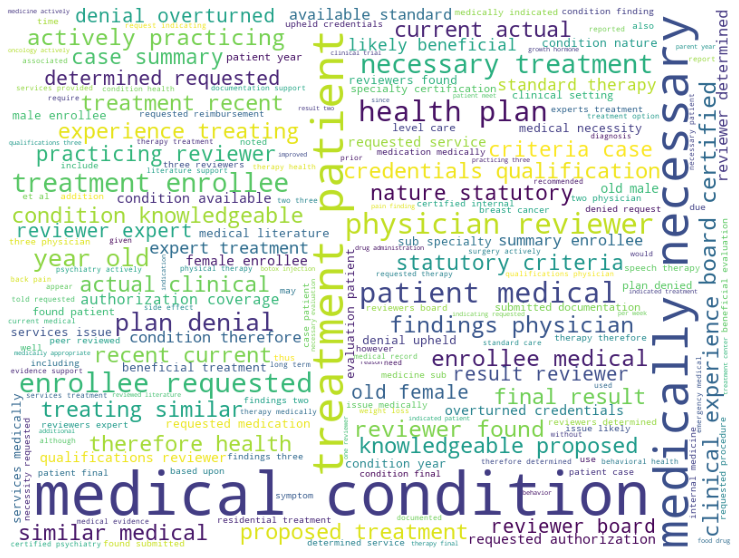

Wall time: 5.11 s


In [108]:
%time displayWordCloud(' '.join(filtered_sentence))

#### 6.2.6 Frequency for misclassification case ####

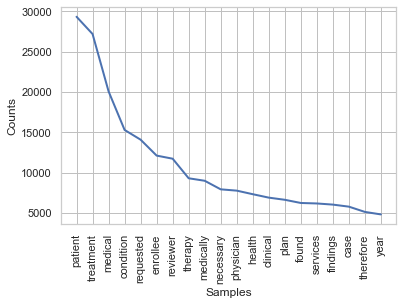

In [109]:
freq_trouble = nltk.FreqDist(filtered_sentence)
freq_trouble.plot(20)

### 6.3 NLP for correctly classified cases ###

#### 6.3.1 Combine all sentences from data which was determined to correctly classified cases ####

In [110]:
safe_total=[]
filtered_sentence_safe = []
for i in safe_findings.Findings:
    safe_total.append(i)

In [111]:
for i in safe_total:
    letters_only = re.sub('[^a-zA-Z]',' ',i) # If it's not English, remove it
    lower_case = letters_only.lower()        # Make every words as lower_case
    words = word_tokenize(lower_case)        # Tokenize sentence
    for w in words:
        if w not in stop_words:              
            filtered_sentence_safe.append(w)

In [112]:
print(len(filtered_sentence_safe))

1925828


In [113]:
print(filtered_sentence_safe[800000:800010])

['obese', 'patients', 'endocrine', 'society', 'clinical', 'practice', 'guidelines', 'list', 'arginine', 'alone']


#### 6.3.4 Like trouble cases, we skip stemming section ###

#### 6.3.5 Visualization for correctly classified cases ####

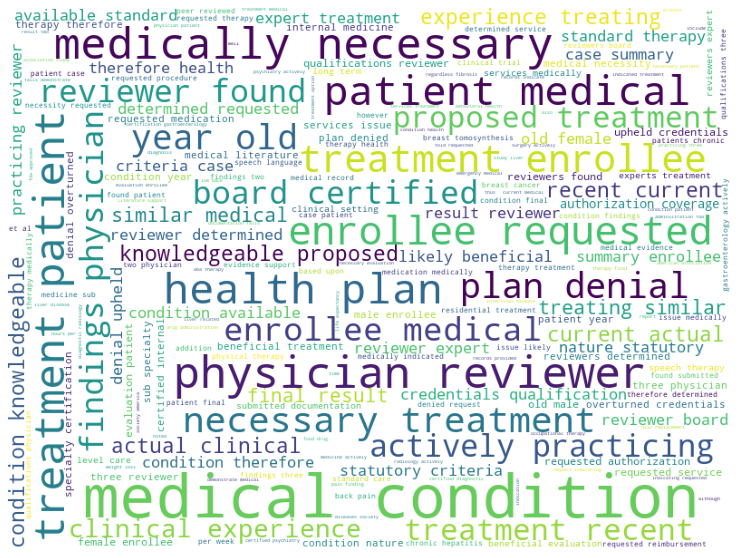

Wall time: 8 s


In [114]:
%time displayWordCloud(' '.join(filtered_sentence_safe))

#### 6.3.6 Frequency for correctly classified case ####

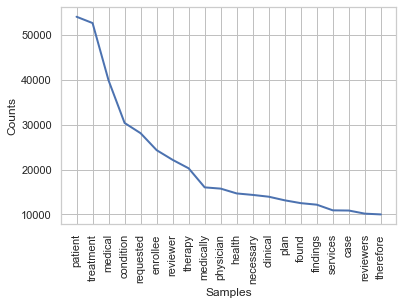

In [115]:
freq_safe = nltk.FreqDist(filtered_sentence_safe)
freq_safe.plot(20)

### 6.4 Compare two groups ###

In [116]:
freq_trouble

FreqDist({'patient': 29335, 'treatment': 27192, 'medical': 20069, 'condition': 15283, 'requested': 14072, 'enrollee': 12098, 'reviewer': 11713, 'therapy': 9283, 'medically': 8974, 'necessary': 7910, ...})

In [117]:
freq_safe

FreqDist({'patient': 54094, 'treatment': 52685, 'medical': 39880, 'condition': 30397, 'requested': 28107, 'enrollee': 24329, 'reviewer': 22161, 'therapy': 20274, 'medically': 16027, 'physician': 15746, ...})

As you can see in freqency, too many words are overlapping. 
So, I have to find some difference between two groups 

#### 6.4.1 Change freq_dist to data.frame ####

In [118]:
df_trouble = pd.DataFrame.from_dict(freq_trouble, orient='index')
df_trouble.columns = ['Frequency']
df_trouble.index.name = 'Term'
print(df_trouble)

              Frequency
Term                   
year               4797
old                4479
female             2660
enrollee          12098
requested         14072
...                 ...
disk                  2
lbp                   2
cornerstones          1
sufferers             1
lapse                 1

[19233 rows x 1 columns]


In [119]:
df_safe = pd.DataFrame.from_dict(freq_safe, orient='index')
df_safe.columns = ['Frequency']
df_safe.index.name = 'Term'
print(df_safe)

            Frequency
Term                 
patient         54094
year             9222
old              8556
female           4906
requested       28107
...               ...
ruggenenti          1
alta                1
bates               1
labored             1
goorhius            1

[23419 rows x 1 columns]


#### 6.4.2 Merge two data.frame to one data.frame ####

I replaced NA with 0 because NA of frequency means 0 
Also, after merging two data.frame, I made one more variable which indicates ratio of frequency.
Subsequently I sorted data by proportion

In [120]:
merged_words = df_trouble.join(df_safe, lsuffix='_trouble', rsuffix='_safe').fillna(0)
merged_words['divide2'] = merged_words['Frequency_safe']/merged_words['Frequency_trouble']
sorted_by_diff2 = merged_words.sort_values(by=['divide2'], ascending=False)

#### 6.4.3 Select words which can lead data to correct classification ####

In [121]:
sorted_by_diff2 = sorted_by_diff2[sorted_by_diff2['divide2'] > 8]

In [122]:
sorted_by_diff2 = sorted_by_diff2[sorted_by_diff2['Frequency_safe'] > 10]

In [123]:
sorted_by_diff2 = sorted_by_diff2[sorted_by_diff2['Frequency_trouble'] <3]

In [124]:
sorted_by_diff2

,Frequency_trouble,Frequency_safe,divide2
Term,,,
reader,1,84.0,84.0
mthfr,1,72.0,72.0
skaane,1,66.0,66.0
hdl,1,64.0,64.0
western,1,60.0,60.0
...,...,...,...
durations,2,18.0,9.0
mirena,2,17.0,8.5
handling,2,17.0,8.5


Below are the words which were appeared in correct classification

In [125]:
print(sorted_by_diff2.index)

Index(['reader', 'mthfr', 'skaane', 'hdl', 'western', 'committees', 'dexcom',
       'blot', 'pathogenetic', 'fibrinogen',
       ...
       'alarm', 'nicotine', 'heating', 'retrieval', 'psychologists',
       'durations', 'mirena', 'handling', 'oncotypedx', 'propulsion'],
      dtype='object', name='Term', length=187)


#### 6.4.4 Divide test dataset into automatic classification and manual classification by staff member. ####


In [126]:
speciality2=[]
options = sorted_by_diff2.index
      
for i in test_final_data.Findings:
    for w in options:
        ss = w
        words = word_tokenize(i)    
        if ss in words:
            speciality2.append('Yes')
            break
    
    else:
        speciality2.append('No')
 
test_final_data['speciality2']=speciality2

In [127]:
staff_work2 = test_final_data[test_final_data.speciality2=='No']
for_classification2 = test_final_data[test_final_data.speciality2=='Yes']
print('Test data was divided into two group')
print(len(for_classification2),' rows among test data can be used to classification model.')
print(len(staff_work2),'rows among test data should be solved by manual classification by staff member.')

Test data was divided into two group
444  rows among test data can be used to classification model.
4989 rows among test data should be solved by manual classification by staff member.


In [128]:
y_test = for_classification2['Determination']
X_test = for_classification2.drop(['Determination','Findings','speciality2'],axis=1)

#### 6.4.5 Classification accuracy  ####

In [129]:
print("Test Accuracy : {:.3f}".format(detailed_NB.score(X_test,y_test)))

Test Accuracy : 0.797


#### 6.4.6 Change threshold ####

Basically, Naive Bayes model have 0.5 as threshold. 
However, in order to classify more correctly, I can increase threshold as 0.7 and send the rest of the data to manual classification by staff members.

In [130]:
overturned_clear = X_test[detailed_NB.predict_proba(X_test)[:,0]>0.7]     # Over 70% probability for overturned
overturned_clear_y = y_test[detailed_NB.predict_proba(X_test)[:,0]>0.7]
upheld_clear = X_test[detailed_NB.predict_proba(X_test)[:,1]>0.7]         # Over 70% probability for upheld
upheld_clear_y = y_test[detailed_NB.predict_proba(X_test)[:,1]>0.7]

In [131]:
clear_case = pd.concat([overturned_clear, upheld_clear])
clear_case_y = pd.concat([overturned_clear_y, upheld_clear_y])

In [132]:
print('As you can see, ',len(clear_case),' cases beyond threshold from ',len(for_classification2),' cases.')

As you can see,  307  cases beyond threshold from  444  cases.


#### 6.4.7 Classification accuracy with more strict threshold ####

In [133]:
print('Those ',len(clear_case)," cases classification accuracy : {:.3f}".format(detailed_NB.score(clear_case,clear_case_y)))

Those  307  cases classification accuracy : 0.870
